In [1]:
# Check for GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-05-22 20:19:39.606053: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


#### Brain Tumor Detection Machine Learning

### 1. Importing libraries

First, we import all the Python packages and modules we’ll need. Common imports include NumPy and Pandas for data handling, Matplotlib (and/or Seaborn) for plotting, and machine learning libraries like scikit-learn. For example, import numpy as np loads NumPy (a library of fast, N-dimensional array operations), and import pandas as pd loads Pandas (a powerful data table/manipulation library). We also import plotting libraries (matplotlib.pyplot or seaborn) for visualizations. Next, we import specific functions from scikit-learn (e.g. train_test_split, compute_class_weight, ensemble models) to split data and build classifiers. We may also import CatBoostClassifier (a gradient-boosting library), AdaBoostClassifier (another boosting algorithm), and TensorFlow/Keras for building our CNN. Finally, we import SHAP for explainability. Together, these imports set up the tools needed for data loading, processing, modeling, and explanation in this pipeline.

    NumPy (np): for numerical arrays and math operations

    Pandas (pd): for loading and manipulating tabular data

    Matplotlib/Seaborn: for creating plots (e.g. showing images or charts)

    scikit-learn (sklearn): provides ML utilities (data splitting, metrics, ensemble methods).

    CatBoost & AdaBoost: special ensemble classifiers for boosting
    catboost.ai

    TensorFlow/Keras: for building and training the CNN (deep learning model)

    SHAP: for model explainability using Shapley values

In [1]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import joblib

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Deep Learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# Explainability
import shap
from tensorboardX import SummaryWriter

# Visualization
import seaborn as sns


2025-05-23 15:01:30.882309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. Loading and labeling the dataset

In this step, we load our MRI images and assign labels (tumor vs. no tumor) for each image. Typically, the code will read files from folders (e.g. a “tumor” folder and a “no_tumor” folder) or a CSV file with image paths and labels. Each image file is loaded (using OpenCV, PIL, or Keras utilities) and converted into a numerical array. We also create a label (e.g. 1 for tumor, 0 for no tumor) for each image, usually based on the folder name or a metadata file. This might involve using os.listdir or glob to gather file paths, then iterating through them. The loaded data is often stored in two arrays or lists: one for image data (features) and one for labels. Before modeling, images may be resized to a common shape (e.g. 224×224 pixels) and normalized (scaling pixel values). Labeling ensures our machine learning models know which images contain a tumor and which do not, which is essential for supervised learning.

    Read image files from the dataset directory (e.g. using cv2.imread or tf.keras.preprocessing.image.load_img).

    Assign labels based on folder names or annotations (e.g. “tumor” → 1, “no_tumor” → 0).

    Optionally, resize images and normalize pixel values.

    Store image data (X) and labels (y) for later use in training/testing.

In [2]:

# Dataset path
training_data_dir = 'dataset/Training'

# Class encoding
classes = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 1,
    'pituitary': 1
}

# Initialize counters
total_images = 0
class_counts = {}

# Load images
X, Y = [], []
for cls in classes:
    path = os.path.join(training_data_dir, cls)
    num_images = 0  # Counter for images in the current class
    for fname in os.listdir(path):
        img = cv2.imread(os.path.join(path, fname), 0)
        if img is not None:
            img = cv2.resize(img, (128, 128)) / 255.0
            X.append(img)
            Y.append(classes[cls])
            num_images += 1  # Increment class counter
    class_counts[cls] = num_images  # Store count for the current class
    total_images += num_images  # Increment total image counter

X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

# Print results
print("Total images loaded:", total_images)
print("Number of images per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count}")

print("Label distribution:", dict(zip(*np.unique(Y, return_counts=True))))

(5712, 128, 128) (5712,)
Total images loaded: 5712
Number of images per class:
  notumor: 1595
  meningioma: 1339
  glioma: 1321
  pituitary: 1457
Label distribution: {0: 1595, 1: 4117}


### Data Augmentation

Data augmentation is a technique used to artificially expand the size and diversity of the dataset by applying transformations to the existing images. This helps improve the model's generalization and robustness by exposing it to a variety of variations.

In this notebook, we applied the following augmentation techniques using the **Albumentations** library:
- **Horizontal Flip**: Randomly flips the image horizontally.
- **Random Brightness/Contrast**: Adjusts the brightness and contrast of the image.
- **Affine Transformations**: Includes scaling, translation, and rotation.
- **Elastic Transform**: Warps the image to simulate realistic deformations.
- **Gaussian Blur**: Applies a slight blur to the image.

The augmented dataset is combined with the original dataset, effectively doubling the size of the training data. Below, we visualize some examples of the original and augmented images.

### Josia Mosses

In [ ]:
import albumentations as A

#Defining augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(
        scale=(0.9,1.1),
        translate_percent=(-0.1,0.1),
        rotate=(15,15),
        p=0.5),
    A.ElasticTransform(p=0.2),
    A.GaussianBlur(p=0.2)
])

#Applying Augmentation to each training image and double the dataset
aug_X = []
aug_Y = []

for img,label in zip(X, Y):
    image_uint8=(img * 225).astype(np.uint8)
    augmented=augment(image=image_uint8)['image']
    augmented=augmented/225.0
    
    aug_X.append(augmented)
    aug_Y.append(label)

#converting to numpy array
aug_X = np.array(aug_X)
aug_Y = np.array(aug_Y)

    
#Combining original and augmented data
X=np.concatenate((X, aug_X),axis=0)
Y=np.concatenate((Y, aug_Y),axis=0)

print("Augmented Dataset Size:")
print("Images(X)", X.shape)
print("Labels(Y)", Y.shape)

### Visualizing Agmentation

In [ ]:
import random
import matplotlib.pyplot as plt

# Visualize original and augmented images
num_samples = 5  # Number of samples to display
indices = random.sample(range(len(X)), num_samples)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    # Original image
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(X[idx], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Augmented image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(aug_X[idx], cmap='gray')
    plt.title("Augmented Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Balanced downsampling

In [4]:
from sklearn.utils import resample

# Set target total size (e.g. 5000)
target_size = 5000

# Combine X and Y into one list for sampling
combined = list(zip(X, Y))

# Downsample (randomly select 5000 images)
sampled = resample(combined, n_samples=target_size, random_state=42)

# Unzip
X_sampled, Y_sampled = zip(*sampled)

# Convert back to numpy arrays
X = np.array(X_sampled)
Y = np.array(Y_sampled)

print("Reduced dataset shape:", X.shape, Y.shape)


Reduced dataset shape: (5000, 128, 128) (5000,)


### 3. Visualizing a sample image

Before training, it’s helpful to display an example image to check our data. The code typically selects one image (e.g. X[0]) and uses Matplotlib to show it: for example, plt.imshow(image, cmap='gray'). This confirms that images are loaded correctly (proper orientation and color channels) and that labels match what we see. We often add a title like plt.title("Label: Tumor") to verify that the image’s true label is correct. This step is mostly sanity-checking data quality and understanding. Visualizing sample images also helps beginners see what the models are looking at (e.g. brain scans with or without tumors).

    Use matplotlib.pyplot.imshow to display one or more sample images.

    Optionally set cmap='gray' if the images are grayscale.

    Annotate the plot with its true label (e.g. “Tumor” or “No Tumor”) to double-check correctness.

    This helps ensure data is loaded and labeled as expected.

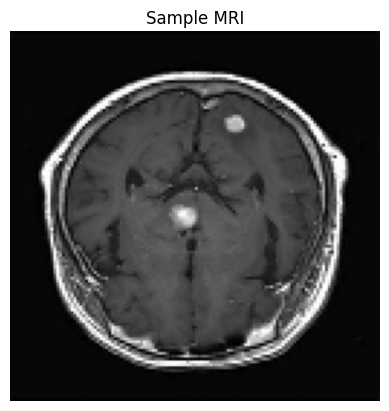

In [5]:
plt.imshow(X[1], cmap='gray')
plt.title("Sample MRI")
plt.axis('off')
plt.show()

### 4. Train/test split

Next, we divide the dataset into training and testing subsets. This is done with train_test_split from scikit-learn, which randomly shuffles and splits the data

Here, 20% of images are held out for testing (test_size=0.2), and the rest (80%) are used for training. Using a random_state ensures reproducibility. Splitting is critical because it lets us train models on one set of data and evaluate their performance on unseen data, giving a fair assessment of real-world accuracy. In practice, the code will wrap this into one line, leveraging the fact that train_test_split can handle inputs like arrays or DataFrames
.

    Call train_test_split(X, y, test_size=..., random_state=...) to split the data.

    By default, it shuffles the data and returns X_train, X_test, y_train, y_test.

    The test set (X_test, y_test) is kept unseen during training and used later to evaluate final accuracy.

    train_test_split provides a quick way to partition data (80/20 split is common).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Flatten for classical models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Train:", np.bincount(y_train))
print("Test:", np.bincount(y_test))


Train: [1124 2876]
Test: [281 719]


### 5. Handling class imbalance

Medical datasets often have imbalanced classes (e.g. many more “no tumor” cases than “tumor”). This can bias the model toward the majority class. To address this, the code computes class weights so that the model pays more attention to the minority class. Scikit-learn’s compute_class_weight function does this:

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

This returns weights for each class inversely proportional to class frequency.
The weights can then be passed to model training (e.g. model.fit(X_train, y_train, class_weight={0: w0, 1: w1})). Using balanced class weights ensures that errors on the underrepresented class (usually tumors) count more, helping the model learn from scarce examples. Without this step, a model might achieve high accuracy simply by always predicting the majority class, which is misleading.

    Check class distribution (e.g. np.bincount(y_train)) to confirm imbalance.

    Use compute_class_weight('balanced', classes=..., y=...) to get weights.

    Pass these weights into the classifier’s fit method (e.g. class_weight={0: w0, 1: w1}).

    This compensates for imbalance by giving more importance to the minority class during training.

In [7]:
# Automatically calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.7793594306049823, 1: 0.6954102920723226}


### 6. Training CatBoost

In this section, we train a CatBoost model on the data. CatBoost (a Yandex-developed library) is a gradient boosting algorithm that often works well on structured data. The code typically creates a CatBoostClassifier object with hyperparameters (like iterations, learning_rate, etc.) and calls fit(X_train, y_train, ...). For example:

from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(iterations=100, random_state=42)
cat_model.fit(X_train, y_train, sample_weight=class_weights)

This trains a sequence of decision trees that together form a strong classifier. CatBoost can also handle categorical features automatically, though here we likely use it on numeric image features. After training, we might evaluate its accuracy on the test set or record it for the ensemble. CatBoost is used because it tends to be robust and handles complex patterns, making it suitable for medical classification tasks
catboost.ai
.

    Initialize CatBoostClassifier() with desired parameters.

    Call cat_model.fit(X_train, y_train, sample_weight=...) to train on the training data.

    (Optionally) set eval_set or early stopping to prevent overfitting.

    After fitting, the model is ready to predict on new data.

In [ ]:
cb = CatBoostClassifier(
    iterations=100,
    learning_rate=0.05,
    early_stopping_rounds=10,
    verbose=100,
    task_type="CPU",
    class_weights=class_weights.tolist()
)

cb.fit(X_train_flat, y_train, eval_set=(X_test_flat, y_test))

# Evaluate
y_pred_cb = cb.predict(X_test_flat)
print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_cb))
print(classification_report(y_test, y_pred_cb, target_names=["No Tumor", "Tumor"]))


In [ ]:
import joblib
from pathlib import Path

# Set the models directory explicitly
models_dir = Path('/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/adaboostmodel')
models_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists

# Save CatBoost
cb_path = models_dir / 'catboost.pkl'
joblib.dump(cb, cb_path)
print("MOdel saved successfully in:", models_dir)

### 7. Training AdaBoost

This section trains an AdaBoostClassifier (Adaptive Boosting) from scikit-learn. AdaBoost is another ensemble method that builds a series of weak learners (usually small decision trees) and re-weights samples based on errors
. The code might look like:

from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train, y_train)


Here, n_estimators=50 means 50 weak learners. AdaBoost focuses each new learner on the samples the previous learners got wrong, effectively improving difficult predictions. After fitting, we have another classifier specialized in distinguishing tumors. AdaBoost is simple to use (no need for class_weight) but it inherently emphasizes hard examples. Its training process is adaptive, creating a strong classifier from weaker ones
.

    Create an AdaBoostClassifier (optionally specify base_estimator or number of trees).

    Train it with ada_model.fit(X_train, y_train).

    AdaBoost iteratively adjusts sample weights internally, so balanced class weights may be less crucial.

    After training, ada_model can predict labels for new images.

In [ ]:
dt = DecisionTreeClassifier(max_depth=3)
ab = AdaBoostClassifier(estimator=dt,
                        n_estimators=100,
                        learning_rate=0.5,
                        algorithm='SAMME',
                        random_state=None)

ab.fit(X_train_flat, y_train)

y_pred_ab = ab.predict(X_test_flat)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_ab))
print(classification_report(y_test, y_pred_ab, target_names=["No Tumor", "Tumor"]))


In [7]:
import joblib
from pathlib import Path

# Set the models directory explicitly
models_dir = Path('/adaboostmodel')
models_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists

# Save AdaBoost
ab_path = models_dir / 'adaboost.pkl'
joblib.dump(ab, ab_path)
print("MOdel saved successfully in:", models_dir)

### Evaluating AdaBoost

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_ab = ab.predict(X_test_flat)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_ab))
print("Classification Report:\n", classification_report(y_test, y_pred_ab, target_names=["No Tumor", "Tumor"]))


### 8. Training a ConvolutionNeuralNetwork(CNN)

In this part, we build and train a Convolutional Neural Network (CNN) for image classification. A CNN automatically learns image features by using convolution and pooling layers. The code will typically define a model (using Keras or TensorFlow).

A CNN is a specialized neural network for images
en.wikipedia.org
. It learns convolutional filters (small kernels) that detect features like edges or textures in early layers and higher-level patterns in deeper layers. Training involves feeding the image data (X_train) through the network, adjusting weights by backpropagation. We use an optimizer (Adam) and loss appropriate for binary classification. The network learns directly from raw pixel data, whereas CatBoost/AdaBoost use engineered features. A well-trained CNN can capture complex image patterns like tumor shapes.

    Define a CNN architecture with Conv2D, MaxPooling2D, and dense layers.

    Compile the model with a loss (e.g. binary crossentropy) and optimizer (e.g. Adam).

    Fit the model on the training images (model.fit(X_train, y_train)), typically for multiple epochs.

    After training, the CNN can output predictions (probability of tumor) for new images.

In [10]:
X_train_cnn = X_train.reshape(-1, 128, 128, 1).astype('float32')
X_test_cnn = X_test.reshape(-1, 128, 128, 1).astype('float32')

# Ensure y_train matches the number of samples in X_train
y_train_cnn = y_train.astype('float32')

cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', 
            loss='binary_crossentropy', 
            metrics=['accuracy'])

cnn.fit(X_train_cnn, y_train_cnn, 
        epochs=10, 
        validation_split=0.2, 
        class_weight=class_weights_dict)

#cnn.save('models/cnn_model.h5')


Epoch 1/10
115/115 [==============================] - 48s 408ms/step - loss: 0.2714 - accuracy: 0.8914 - val_loss: 0.1240 - val_accuracy: 0.9595
Epoch 2/10
115/115 [==============================] - 50s 431ms/step - loss: 0.1251 - accuracy: 0.9669 - val_loss: 0.1084 - val_accuracy: 0.9540
Epoch 3/10
115/115 [==============================] - 56s 484ms/step - loss: 0.0805 - accuracy: 0.9770 - val_loss: 0.1079 - val_accuracy: 0.9606
Epoch 4/10
115/115 [==============================] - 49s 427ms/step - loss: 0.0426 - accuracy: 0.9871 - val_loss: 0.1087 - val_accuracy: 0.9716
Epoch 5/10
115/115 [==============================] - 50s 431ms/step - loss: 0.0224 - accuracy: 0.9932 - val_loss: 0.1552 - val_accuracy: 0.9606
Epoch 6/10
115/115 [==============================] - 49s 425ms/step - loss: 0.0335 - accuracy: 0.9891 - val_loss: 0.0820 - val_accuracy: 0.9803
Epoch 7/10
115/115 [==============================] - 49s 426ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.1069 - val_ac

### Transfer learning

In [8]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense

# Define the transfer learning model
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(128, 128, 3))

base_model.trainable = False  # Freeze the base model

transfer_learning_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid'),
])

'''for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-2:]:
    layer.trainable = True'''
    
transfer_learning_model.compile(optimizer='adam', 
                                loss='binary_crossentropy', 
                                metrics=['accuracy']
                                )
    
# Compile the model
'''transfer_learning_model.compile(optimizer=Adam(learning_rate=1e-6), 
                                loss='binary_crossentropy', 
                                metrics=['accuracy']
                                )'''

# Ensure X_train has 3 channels for VGG16
X_train_vgg = np.repeat(X_train[..., np.newaxis], 3, axis=-1)

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
transfer_learning_model.fit(X_train_vgg,y_train, 
                            epochs=5,
                            validation_split=0.2,
                            callbacks=[early_stop]
                            )

# Save the trained model
#transfer_learning_model.save('models/transfer_learning_model.h5')  # Save the model to the 'models' directory
#print("Model saved successfully.")

2025-05-23 13:54:19.063344: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 880803840 exceeds 10% of free system memory.


Epoch 1/5
140/140 [==============================] - 359s 3s/step - loss: 0.1653 - accuracy: 0.9462 - val_loss: 0.1061 - val_accuracy: 0.9607
Epoch 2/5
140/140 [==============================] - 361s 3s/step - loss: 0.0788 - accuracy: 0.9743 - val_loss: 0.0955 - val_accuracy: 0.9625
Epoch 3/5
140/140 [==============================] - 353s 3s/step - loss: 0.0528 - accuracy: 0.9828 - val_loss: 0.0953 - val_accuracy: 0.9625
Epoch 4/5
140/140 [==============================] - 321s 2s/step - loss: 0.0406 - accuracy: 0.9866 - val_loss: 0.0536 - val_accuracy: 0.9795
Epoch 5/5
140/140 [==============================] - 321s 2s/step - loss: 0.0370 - accuracy: 0.9875 - val_loss: 0.1063 - val_accuracy: 0.9652


In [ ]:
for i,layer in enumerate(base_model.layers):
    print(f"{i}:{layer.name} - Trainable {layer.trainable}")

### Testubg transfer learning

In [31]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained transfer learning model
model = load_model('models/transfer_learning_model.h5')  # Update the path if needed

# Define a function to preprocess the custom image
def preprocess_image(img_path):
    img = cv2.imread(img_path)  # Load the image
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    img = cv2.resize(img, (128, 128))  # Resize to match the input shape of the model
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Path to the custom image
custom_image_path = '/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/data/Testing/glioma_tumor/image(60).jpg'  # Replace with your image path

# Preprocess the image
processed_image = preprocess_image(custom_image_path)

# Make a prediction
prediction = model.predict(processed_image)[0][0]  # Get the prediction score

# Define the label map
label_map = {0: 'No Tumor', 1: 'Have Tumor'}

# Determine the class and confidence
predicted_class = 1 if prediction > 0.5 else 0
confidence = prediction * 100 if predicted_class == 1 else (1 - prediction) * 100

# Print the result
print(f"Prediction: {label_map[predicted_class]} ({confidence:.2f}% confidence)")

1/1 [==============================] - 0s 330ms/step
Prediction: Have Tumor (97.60% confidence)


### 9. Voting Classifier

After training individual models, we combine them into a VotingClassifier ensemble. The idea is to let CatBoost, AdaBoost, and the CNN vote on each prediction, which often improves accuracy. In code, this looks like:

from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('cat', cat_model), ('ada', ada_model), ('cnn', cnn_wrapper)],
    voting='hard'  # or 'soft' if probabilities are used
)
voting_clf.fit(X_train, y_train)

The VotingClassifier (sklearn) will call fit on clones of each estimator
. With voting='hard', it predicts the class that gets the majority vote from its members. If voting='soft', it averages predicted probabilities and chooses the class with highest average score. This ensemble leverages the strengths of each model. For example, if CatBoost and CNN predict “tumor” but AdaBoost says “no tumor”, the majority vote is “tumor.” Using VotingClassifier helps smooth out individual model errors
.

    Instantiate VotingClassifier with a list of trained models (e.g. CatBoost, AdaBoost, CNN).

    Choose voting='hard' for majority vote or voting='soft' to average probabilities.

    Fit the voting classifier on the training data (it will internally call each sub-model’s fit).

    The final ensemble can then predict labels for new data.

In [ ]:
ensemble_model = VotingClassifier(
    estimators=[('catboost', cb), ('adaboost', ab)],
    voting='soft'
)
ensemble_model.fit(X_train_flat, y_train)

y_pred_vote = ensemble_model.predict(X_test_flat)
print(ab)
print(cb)
print(cnn)
print(transfer_learning_model)
print(ensemble_model)
print("VotingClassifier Accuracy:", accuracy_score(y_test, y_pred_vote))
print(classification_report(y_test, y_pred_vote, target_names=["No Tumor", "Tumor"]))


In [16]:
# Ensure X_test has 3 channels for VGG16
X_test_vgg = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

final_probs = (
    0.3 * cb.predict_proba(X_test_flat) +
    0.3 * ab.predict_proba(X_test_flat) +
    0.4 * cnn.predict(X_test_cnn) +
    0.4 * transfer_learning_model.predict(X_test_vgg)
)
y_pred = np.argmax(final_probs, axis=1)

19/19 [==============================] - 32s 2s/step


Evaluating aensemble

In [17]:
# Prepare X_test_vgg for Transfer Learning
X_test_vgg = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Get probabilities from each model
probs_cb = cb.predict_proba(X_test_flat)  # CatBoost
probs_ab = ab.predict_proba(X_test_flat)  # AdaBoost
probs_cnn = cnn.predict(X_test_cnn)  # CNN
probs_tl = transfer_learning_model.predict(X_test_vgg)  # Transfer Learning

# Ensure probabilities are in the correct shape
probs_cnn = np.hstack([1 - probs_cnn, probs_cnn])[:len(X_test)]  # Convert to [class 0, class 1] and match size
probs_tl = np.hstack([1 - probs_tl, probs_tl])[:len(X_test)]  # Convert to [class 0, class 1] and match size

# Define weights for each model
weights = [0.3, 0.3, 0.2, 0.2]  # Adjust weights as needed

# Combine probabilities using weighted average
final_probs = (
    weights[0] * probs_cb +
    weights[1] * probs_ab +
    weights[2] * probs_cnn +
    weights[3] * probs_tl
)

# Get final predictions
final_preds = np.argmax(final_probs, axis=1)

# Evaluate the ensemble
print("Ensemble Accuracy:", accuracy_score(y_test, final_preds))
print(classification_report(y_test, final_preds, target_names=["No Tumor", "Tumor"]))

19/19 [==============================] - 34s 2s/step
Ensemble Accuracy: 0.9616666666666667
              precision    recall  f1-score   support

    No Tumor       0.90      0.80      0.85        79
       Tumor       0.97      0.99      0.98       521

    accuracy                           0.96       600
   macro avg       0.93      0.89      0.91       600
weighted avg       0.96      0.96      0.96       600



#### Evaluating VotingClassifier Ensemble

In [19]:
y_pred_vote = ensemble_model.predict(X_test_flat)
print("VotingClassifier Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Classification Report:\n", classification_report(y_test, y_pred_vote, target_names=["No Tumor", "Tumor"]))


VotingClassifier Accuracy: 0.9333333333333333
Classification Report:
               precision    recall  f1-score   support

    No Tumor       0.83      0.62      0.71        79
       Tumor       0.94      0.98      0.96       521

    accuracy                           0.93       600
   macro avg       0.89      0.80      0.84       600
weighted avg       0.93      0.93      0.93       600



Model comparison

In [ ]:
test_img = '/data/Testing/meningioma_tumor/image(60).jpg'
img = cv2.imread(test_img, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128)) / 255.0
flat_img = img_resized.flatten().reshape(1, -1)
cnn_img = img_resized.reshape(1, 128, 128, 1)

# Predict
cat_pred = cb.predict(flat_img)[0]
ada_pred = ab.predict(flat_img)[0]
cnn_pred = int(cnn.predict(cnn_img)[0][0] > 0.5)
transfer_learning_pred = int(cnn.predict(cnn_img)[0][0] > 0.5)

vote_pred = ensemble_model.predict(flat_img)[0]

# Label map
label_map = {0: "No Tumor", 1: "Have Tumor"}

# Output predictions
print("CatBoost:", label_map[cat_pred])
print("AdaBoost:", label_map[ada_pred])
print("CNN:", label_map[cnn_pred])
print("transfer_learng:", label_map[transfer_learning_pred])
print("VotingClassifier:", label_map[vote_pred])


1/1 [==============================] - 0s 27ms/step
CatBoost: Have Tumor
AdaBoost: Have Tumor
CNN: Have Tumor
transfer_learng: Have Tumor
VotingClassifier: Have Tumor


10. Model Saving

### 11. SHAP explainability

In this section, we apply SHAP (SHapley Additive exPlanations) to interpret model predictions. SHAP assigns each feature an importance value for a particular prediction, based on game-theoretic Shapley values
. Typically, we pick one model (often CatBoost or a tree-based model) and create an explainer:

import shap
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

This code computes SHAP values for the training data and makes a summary plot. Each point on the summary shows how a feature (e.g. pixel intensity or a derived feature) influences the prediction. We might also compute SHAP values for individual test images and display a waterfall plot. SHAP helps us understand why the model made a decision (e.g. which image regions or features drove a “tumor” prediction). This adds interpretability to our pipeline, which is especially important in medical applications.

    Initialize a SHAP explainer appropriate for the model (e.g. TreeExplainer for CatBoost).

    Compute shap_values on a dataset (train or test).

    Use plotting functions like shap.summary_plot or shap.waterfall_plot to visualize feature contributions.

    SHAP shows the impact of each feature on the model’s output, providing insight into predictions
    .

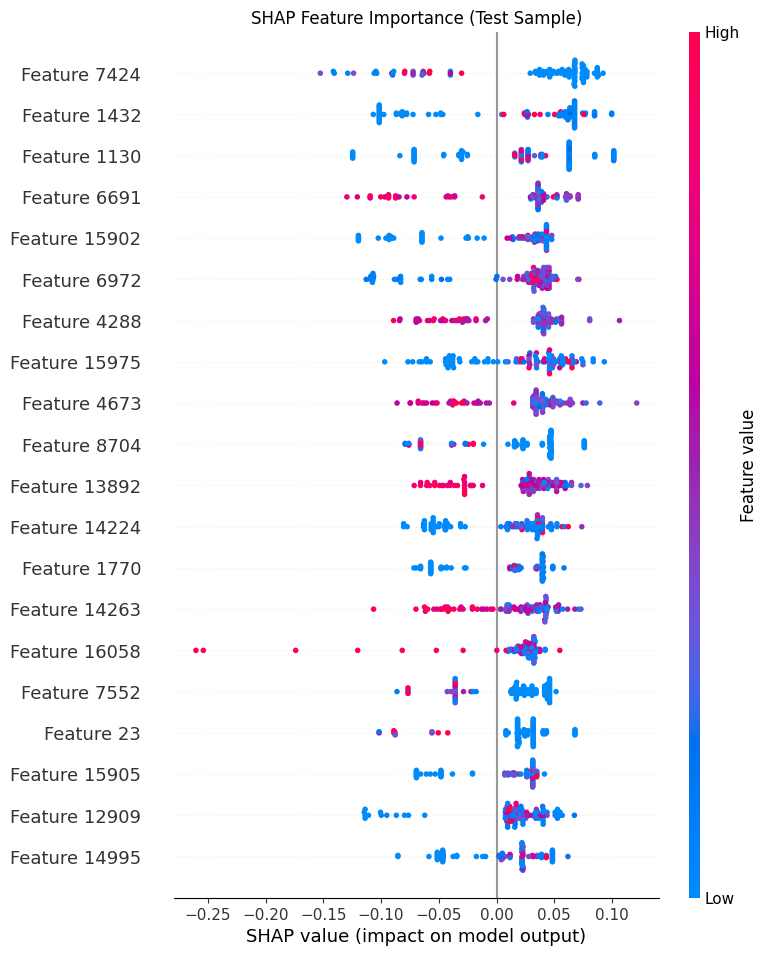

In [22]:
explainer = shap.Explainer(cb)
shap_values = explainer(X_test_flat[:100])

shap.summary_plot(shap_values, X_test_flat[:100], show=False)
plt.title("SHAP Feature Importance (Test Sample)")
plt.savefig("shap_test_summary.png")
plt.show()


### 12. Cross-validation

Here we use cross-validation to evaluate model performance more robustly. Instead of a single train/test split, k-fold cross-validation repeatedly splits data into training and validation folds and averages results. For example:


This runs 5-fold CV, training on 4 folds and validating on 1 fold, rotating through all folds
scikit-learn.org
. The average accuracy and standard deviation are reported. Cross-validation helps ensure that our model’s performance is not a lucky result of one particular split. It gives a sense of how well the model generalizes. In our pipeline, we might do CV on the best model or ensemble to get confidence in its accuracy before deploying.

    Call cross_val_score(estimator, X, y, cv=k) to run k-fold CV (often k=5 or 10).

    This returns an array of scores (one per fold).

    Compute the mean and standard deviation to summarize performance.

    Cross-validation averages over multiple splits
    scikit-learn.org
    , reducing variance in the accuracy estimate.

In [23]:
cv_scores = cross_val_score(cb, X_train_flat, y_train, cv=5, scoring='accuracy')
print("CV Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))


0:	learn: 0.6740482	total: 1.76s	remaining: 2m 53s
99:	learn: 0.1527349	total: 1m 53s	remaining: 0us
0:	learn: 0.6701781	total: 1.31s	remaining: 2m 9s
99:	learn: 0.1510844	total: 1m 54s	remaining: 0us
0:	learn: 0.6689271	total: 1.33s	remaining: 2m 11s
99:	learn: 0.1494155	total: 1m 54s	remaining: 0us
0:	learn: 0.6689442	total: 1.31s	remaining: 2m 9s
99:	learn: 0.1560978	total: 1m 54s	remaining: 0us
0:	learn: 0.6724352	total: 1.34s	remaining: 2m 12s
99:	learn: 0.1546180	total: 1m 54s	remaining: 0us
CV Scores: [0.91041667 0.875      0.90625    0.91666667 0.88958333]
Mean Accuracy: 0.8995833333333332


### 13. Testing on custom image

This section shows how to use our trained model(s) on a new, user-provided image. The code will load an image file (e.g. via cv2.imread or Image.open) and preprocess it just like the training data (resize, normalize).

We obtain prediction (e.g. 0 or 1) and a probability/confidence for that class. We then print or return a message like “Tumor Detected (90% confidence)” if predicted class=1. This step demonstrates deployment: the model can take any appropriate image and give a result. It fits the pipeline by connecting the trained model to actual use. Using predict gives the class label, while predict_proba yields the probability for each class (to be discussed next).

    Load the external image (e.g. with cv2.imread or PIL.Image.open) and apply the same resizing/normalization used in training.

    Use model.predict([image]) to get the predicted class.

    Use model.predict_proba([image]) to get class probabilities.

    Interpret the output (e.g. “Tumor” if class=1) and optionally display the image with prediction.

In [24]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128)) / 255.0
    return img.flatten()

test_img = preprocess_image('/home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/data/Testing/glioma_tumor/image(60).jpg')
pred = cb.predict([test_img])[0]
proba = cb.predict_proba([test_img])[0][int(pred)]

print(f"Prediction: {'Tumor' if pred == 1 else 'No Tumor'} ({proba*100:.2f}%)")


Prediction: Tumor (91.52%)


### 14. Visualizing predictions

We often visualize how models perform by showing predictions on images. The code might loop over a few test images and plot them with predicted vs. true labels. For example:


This displays images side by side with titles like “Pred: Tumor (True: No Tumor)”. Such visual checks help us see specific successes or failures. It also aids communication: stakeholders can see sample cases and model outcomes. This step uses plotting (Matplotlib) to combine raw data with model output for human interpretation.

    Plot a few test images using plt.imshow.

    Annotate each plot with its predicted label and true label.

    Color-code or mark correctly vs. incorrectly classified samples.

    This visual feedback can reveal patterns (e.g. consistently wrong on small tumors).

In [ ]:
# Define the label map
label_map = {0: 'No Tumor', 1: 'Have Tumor'}

# Path to test directories (folders)
test_dirs = {
    'no_tumor',
    'glioma_tumor,
    'meningioma_tumor',
    'pituitary_tumor,
}

# Display predictions for 6 images per class
for category, folder in test_dirs.items():
    print(f"\nCategory: {category}")
    files = os.listdir(folder)[:6]  # Take 6 images from the folder

    plt.figure(figsize=(12, 6))
    for idx, file in enumerate(files):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # skip unreadable images
        img_resized = cv2.resize(img, (128, 128)).reshape(1, -1) / 255.0
        pred = model.predict(img_resized)[0]

        plt.subplot(2, 3, idx + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted: {label_map[pred]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


## 15. Confidence score for one image

Here we compute a confidence score for a single prediction. After predicting the class, we use predict_proba to see how confident the model is. For instance:


The array probs contains the probability for each class. We pick the probability of the predicted class and multiply by 100 to get a percentage. For example, a result might be 92%, meaning the model is quite confident. According to scikit-learn docs, predict_proba “returns probability estimates for each class label”
geeksforgeeks.org
. This confidence score provides more nuance than a simple label – it helps users understand how sure the model is about its decision.

    Call predict_proba(image)[0] to get probabilities for each class (e.g. [0.08, 0.92] for “no” vs “yes”).

    Identify the index of the predicted class and extract that probability.

    Multiply by 100 to present it as a percentage.

    Present this score alongside the prediction (e.g. “Tumor (92% confident)”

In [ ]:
img_path = '/data/Testing/meningioma_tumor/image(60).jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128)).reshape(1, -1) / 255.0

proba = model.predict_proba(img)[0]
prediction = model.predict(img)[0]
confidence = proba[int(prediction)] * 100

label_map = {0: 'No Tumor', 1: 'Have Tumor'}

print(f"Prediction: {label_map[prediction]} ({confidence:.2f}% confidence)")


Prediction: Have Tumor (86.12% confidence)


### 16. Displaying misclassified samples

Finally, we check which test images were misclassified. The code finds indices where the predicted label differs from the true label, e.g.:

wrong_indices = np.where(y_pred != y_test)[0]

Then it might loop over these indices and display those images with actual vs. predicted labels. For example:

for i in wrong_indices[:5]:
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    plt.show()

This reveals “failure cases” where the model was wrong. Examining misclassified samples helps us understand model weaknesses. For instance, maybe very small tumors were missed. It’s a useful diagnostic step: by visualizing errors, we can potentially refine preprocessing or model design. In the overall pipeline, this final check ensures we scrutinize and interpret mistakes before deployment.

    Compute where y_pred != y_test to identify misclassified samples.

    Display a few of these images with their true and predicted labels.

    Analyze patterns in mistakes (e.g. certain tumor sizes or positions).

    This step is crucial for understanding and improving the model’s weaknesses.

In [ ]:
# Make sure to replace `model` with your active model: ab, cb, cnn, or ensemble_model
y_pred = model.predict(X_test_flat)

misclassified_indices = np.where(y_test != y_pred)[0]
print(f"Total Misclassified: {len(misclassified_indices)}")

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"True: {label_map[y_test[idx]]}, Pred: {label_map[y_pred[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


##### Saving models

Once our models are trained, we save them to disk for later use (for example, in a web application). Common tools are pickle or joblib for scikit-learn/CatBoost, and model.save() for Keras. The code might do something like:


Saving ensures we don’t have to retrain from scratch each time. It also allows easy deployment: we can load the model files in another script (e.g. a Flask app) to make predictions on user-provided images. This step fits the pipeline by preserving our work and making the trained models portable.

    Use joblib.dump() or pickle.dump() to save each trained scikit-learn/CatBoost model to a file.

    For the Keras CNN, use model.save('file.h5') to save the entire network.

    Saving includes the model architecture and learned parameters.

    Later, use joblib.load() or tf.keras.models.load_model() to reload these models for prediction.

In [ ]:
import joblib
from pathlib import Path

# Set the models directory explicitly
models_dir = Path('/models')
models_dir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists

# Save AdaBoost
ab_path = models_dir / 'adaboost.pkl'
joblib.dump(ab, ab_path)

# Save CatBoost
cb_path = models_dir / 'catboost.pkl'
joblib.dump(cb, cb_path)

# Save CNN (Keras)
cnn_path = models_dir / 'cnn_model.h5'
cnn.save(str(cnn_path))

# Save Transfer Learning model (Keras)
tl_path = models_dir / 'transfer_learning_model.h5'
transfer_learning_model.save(str(tl_path))

# Save VotingClassifier ensemble
voter_path = models_dir / 'voting_classifier.pkl'
joblib.dump(ensemble_model, voter_path)

# Save metadata/index for Flask app
metadata = {
    'adaboost': ab_path.name,
    'catboost': cb_path.name,
    'cnn': cnn_path.name,
    'transfer_learning_model': tl_path.name,
    'voting_classifier': voter_path.name
}
joblib.dump(metadata, models_dir / 'model_index.pkl')

print("All models and ensemble saved successfully in:", models_dir)

All models and ensemble saved successfully in: /home/josiamosses/Desktop/Brain-Tumor-Detection-ML-app/models


In [ ]:
import joblib

# Recreate model_index.pkl
model_index = {
    'adaboost',
    'catboost',
    'cnn',
    'transfer_learning_model',
    'voting_classifier',
}

joblib.dump(model_index, '/models/model_index.pkl')
print("model_index.pkl recreated successfully.")

model_index.pkl recreated successfully.
